In [115]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
import pandas as pd
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [116]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [117]:
# 데이터 불러오기
past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')
store = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Year']=pd.DatetimeIndex(data.Date).year
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1)

# 데이터 가공 : StateHoliday, Open
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체
open = data[data['Open']==0].index
data.drop(open,inplace=True)


# 결측값 처리
data = data.dropna(axis=0)

# store,open 이름 제거
data = data.drop(['Open'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Year','Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)
digital_data
# 표준화
scaler = MinMaxScaler().fit(digital_data)

digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data=categorey_data, columns=onehotencoding_cols)


# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

# 형 통일
data = data.astype({'Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

pd.options.display.max_columns = None
data['StateHoliday_a'] = data['StateHoliday_a'].replace({True: 1, False: 0})
data

C:\Users\rlaeo\AppData\Local\Temp\ipykernel_23268\2548748974.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')


,Sales,Customers,CompetitionDistance,Year,Month,Day,Store,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_d,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0.126664,0.075122,0.016482,1.0,0.545455,1.000000,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0
1,0.120815,0.073904,0.016482,1.0,0.545455,0.966667,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,0.115087,0.070790,0.016482,1.0,0.545455,0.933333,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,0.120599,0.075799,0.016482,1.0,0.545455,0.900000,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,0.146856,0.082837,0.016482,1.0,0.545455,0.866667,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842201,0.166181,0.063752,0.070280,0.0,0.000000,0.200000,1115,1,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0
842202,0.114823,0.045885,0.070280,0.0,0.000000,0.133333,1115,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
842203,0.109263,0.044126,0.070280,0.0,0.000000,0.100000,1115,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
842204,0.103415,0.040606,0.070280,0.0,0.000000,0.066667,1115,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0


In [118]:
data = data.groupby('Store').get_group(22)

data

,Sales,Customers,CompetitionDistance,Year,Month,Day,Store,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_d,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
16088,0.158023,0.085679,0.013449,1.0,0.545455,1.000000,22,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
16089,0.136820,0.077829,0.013449,1.0,0.545455,0.966667,22,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
16090,0.133595,0.071061,0.013449,1.0,0.545455,0.933333,22,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
16091,0.138649,0.071061,0.013449,1.0,0.545455,0.900000,22,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0
16092,0.171211,0.084055,0.013449,1.0,0.545455,0.866667,22,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16702,0.156603,0.084867,0.013449,0.0,0.000000,0.200000,22,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
16703,0.063657,0.039659,0.013449,0.0,0.000000,0.133333,22,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
16704,0.097543,0.067813,0.013449,0.0,0.000000,0.100000,22,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0
16705,0.093716,0.062534,0.013449,0.0,0.000000,0.066667,22,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [119]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values
seed = 0
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)


In [120]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=seed,shuffle=True)
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

train_data의 row : 495, column : 27


In [121]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim = 27,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mse',
             metrics=['accuracy'])

In [122]:
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=50,
)

Epoch 1/50
8/8 [==============================] - 1s 3ms/step - loss: 2.0479 - accuracy: 0.0000e+00
Epoch 2/50
8/8 [==============================] - 0s 2ms/step - loss: 1.3422 - accuracy: 0.0000e+00
Epoch 3/50
8/8 [==============================] - 0s 2ms/step - loss: 1.0740 - accuracy: 0.0000e+00
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.8653 - accuracy: 0.0000e+00
Epoch 5/50
8/8 [==============================] - 0s 2ms/step - loss: 0.7915 - accuracy: 0.0000e+00
Epoch 6/50
8/8 [==============================] - 0s 2ms/step - loss: 0.7614 - accuracy: 0.0000e+00
Epoch 7/50
8/8 [==============================] - 0s 2ms/step - loss: 0.7109 - accuracy: 0.0000e+00
Epoch 8/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6033 - accuracy: 0.0000e+00
Epoch 9/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.0000e+00
Epoch 10/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6341 - accuracy: 0.0000e+00

In [123]:
y_prediction = model.predict(x_test).flatten()
a = 0
b = 0
for i in range(10):
    label = np.round(y_test[i],3)
    prediction = np.round(y_prediction[i],3)
    print("실제가격 %0.3f 예상 가격 %.3f" %(label,prediction))
    a += label
    b += prediction
a = a/10
b = b/10
print("실제가격 평균값 : %0.3f" %a)
print("실제가격 평균값 : %0.3f" %b)

4/4 [==============================] - 0s 2ms/step
실제가격 0.117 예상 가격 0.153
실제가격 0.117 예상 가격 0.179
실제가격 0.074 예상 가격 0.126
실제가격 0.135 예상 가격 0.170
실제가격 0.100 예상 가격 0.138
실제가격 0.089 예상 가격 0.115
실제가격 0.155 예상 가격 0.192
실제가격 0.106 예상 가격 0.154
실제가격 0.108 예상 가격 0.153
실제가격 0.086 예상 가격 0.138
실제가격 평균값 : 0.109
실제가격 평균값 : 0.152


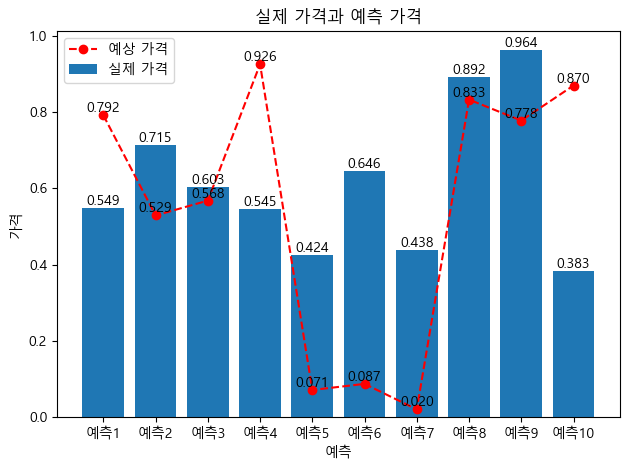

In [124]:
import numpy as np
import matplotlib.pyplot as plt
if os.name == "posix":
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

# 임의의 y_test와 y_prediction 데이터
y_test = np.random.rand(10)
y_prediction = np.random.rand(10)

# 실제 가격과 예측 가격 가져오기 (반올림 처리)
true_prices = np.round(y_test, 3)
predicted_prices = np.round(y_prediction, 3)

# 그래프 생성
x = np.arange(len(true_prices)) + 1
plt.bar(x, true_prices, label='실제 가격')

# 예상 가격 점선으로 표시
plt.plot(x, predicted_prices, linestyle='--', marker='o', color='red', label='예상 가격')

# x축 설정
plt.xticks(x, [f'예측{i+1}' for i in range(len(true_prices))])
plt.xlabel('예측')
plt.ylabel('가격')
plt.title('실제 가격과 예측 가격')
plt.legend()

# 레이블 표시
for i, v in enumerate(true_prices):
    plt.text(x[i], v, f'{v:.3f}', ha='center', va='bottom')

for i, v in enumerate(predicted_prices):
    plt.text(x[i], v, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
